# Time Series Analysis and Forecasting

### Task 1:

Выберите 2 любые компании, которые имеют листинг на фондовом рынке США. Выгрузите дневные данные начиная с 2017 по настоящее время по этим 2-м компаниям и сформируйте датасет для временного ряда (итого у вас 2 датасета). 
<br><b>Цель задания</b> - проведите исследование и статистический анализ временного ряда по сформированным датасетам, посчитайте все основные статистики для временного ряда, превратите ваши временные ряды в стационарные и сформируйте отчет с выводами и визуализациями в jupyter notebook’e.

Без отчета с подкрепленными выводами задание считается проваленным (то есть ноутбук с кодом и картинками мне не присылать).

Итоговая оценка за правильно выполненное задание: <b>3 балла</b>.


<div style='background-color: lightblue; padding: 10px; border-radius: 10px;'>
    <h4 style='color: darkblue;'> yfinance</h4>
</div>

In [1]:
import yfinance as yf
import pandas as pd

Выберем две компании и скачаем данные с 2017, используя библиотеку yfinance.

In [2]:
# Компании
companies = {
    'EPAM': 'EPAM Systems, Inc.',
    'AAPL': 'Apple Inc.'
}

In [3]:
# Даты
start_date = '2017-01-01'
end_date = '2025-04-29'

In [4]:
# Скачивание данных
data = {}
for ticker in companies:
    df = yf.download(ticker, start=start_date, end=end_date)
    df.to_csv(f'{ticker}_daily_data.csv')  # Сохраняем в файл
    data[ticker] = df

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
df.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2017-01-03,26.862427,26.904056,26.540957,26.781481,115127600
2017-01-04,26.832357,26.945683,26.769914,26.793041,84472400
2017-01-05,26.968815,27.026633,26.783795,26.809235,88774400
2017-01-06,27.269468,27.327287,26.936434,27.008128,127007600
2017-01-09,27.519245,27.621006,27.276409,27.278720,134247600


Оставим только цену закрытия торгов, это самый репрезентативный показатель и упростит анализ)

In [6]:
# Оставляем только закрытие
close_data = {ticker: df[['Close']] for ticker, df in data.items()}

In [7]:
df = pd.concat(close_data, axis=1)
df.columns = ['EPAM', 'AAPL']

<div style='background-color: lightblue; padding: 10px; border-radius: 10px;'>
    <h4 style='color: darkblue;'> Dataset</h4>
</div>

In [8]:
import matplotlib.pyplot as plt

In [9]:
df.head()

,EPAM,AAPL
Date,,
2017-01-03,63.660000,26.862427
2017-01-04,64.360001,26.832357
2017-01-05,64.750000,26.968815
2017-01-06,66.870003,27.269468
2017-01-09,66.839996,27.519245


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2091 entries, 2017-01-03 to 2025-04-28
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EPAM    2091 non-null   float64
 1   AAPL    2091 non-null   float64
dtypes: float64(2)
memory usage: 49.0 KB


In [11]:
df.to_csv('closing_price.csv')

У нас теперь есть датафрейм с ценами закрытия акций EPAM и AAPL с 2017 года по сегодняшний день.

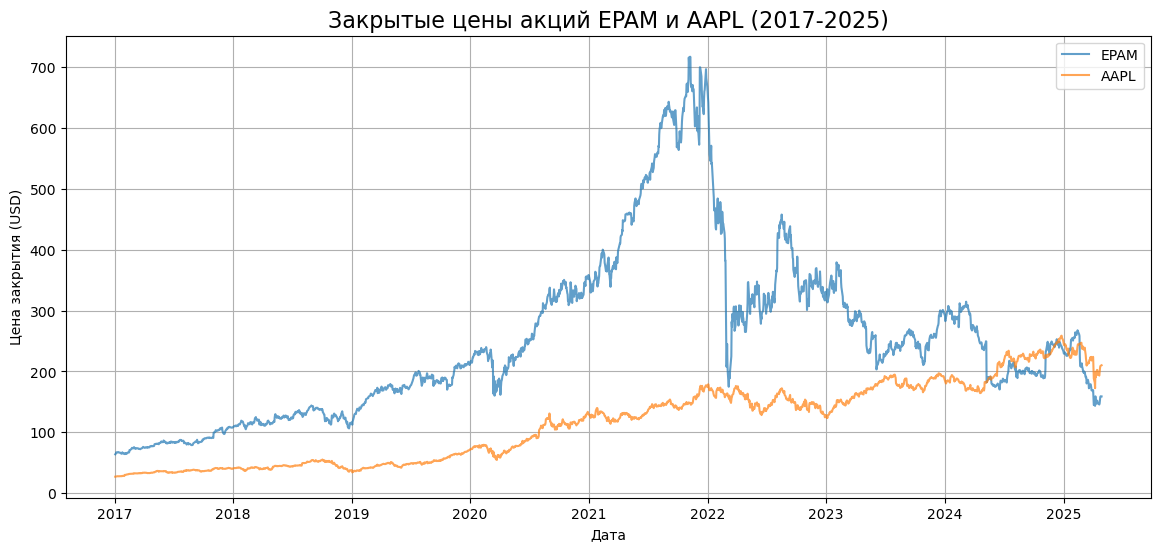

In [12]:
plt.figure(figsize=(14, 6))
# EPAM
plt.plot(df.index, df['EPAM'], label='EPAM', alpha=0.7)
# AAPL
plt.plot(df.index, df['AAPL'], label='AAPL', alpha=0.7)
plt.title('Закрытые цены акций EPAM и AAPL (2017-2025)', fontsize=16)
plt.xlabel('Дата')
plt.ylabel('Цена закрытия (USD)')
plt.legend()
plt.grid(True)
plt.show()

Обе акции показывают заметный тренд роста, но видно, что в разные периоды были спады и волатильность.

<div style='background-color: lightblue; padding: 10px; border-radius: 10px;'>
    <h4 style='color: darkblue;'> Statistics</h4>
</div>

In [13]:
df.describe()

,EPAM,AAPL
count,2091.000000,2091.000000
mean,251.410670,115.650803
std,138.975092,65.078111
min,63.660000,26.832357
25%,143.665001,47.280956
50%,228.070007,124.349594
75%,318.595001,169.140762
max,717.489990,258.735504


In [14]:
stats = df.describe().T
print(f'coef_var: \n{stats['std'] / stats['mean']}')

coef_var: 
EPAM    0.552781
AAPL    0.562712
dtype: float64


<br>Средняя цена:
 - EPAM: 251.41 USD
 - AAPL: 115.65 USD

<br>Стандартное отклонение (разброс цен):
 - EPAM: 138.98
 - AAPL: 65.08

<br>Минимум - максимум:
 - EPAM: от 63.66 до 717.49 USD
 - AAPL: от 26.83 до 258.74 USD

<br>Коэффициент вариации — показатель относительной волатильности:
 - EPAM: 0.55
 - AAPL: 0.56
   
<br>Оба ряда показывают сильный тренд роста и среднюю волатильность.

<div style='background-color: lightblue; padding: 10px; border-radius: 10px;'>
    <h4 style='color: darkblue;'> Augmented Dickey-Fuller test</h4>
</div>

In [15]:
from statsmodels.tsa.stattools import adfuller

In [16]:
def adf_test(series, title=''):
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Statistic', 'p-value', 'Lags Used', 'Observations Used']
    out = pd.Series(result[0:4], index=labels)
    for key, value in result[4].items():
        out[f'Critical Value ({key})'] = value
    return out

In [17]:
adf_results = {
    'EPAM': adf_test(df['EPAM']),
    'AAPL': adf_test(df['AAPL'])
}

In [18]:
pd.DataFrame(adf_results)

,EPAM,AAPL
ADF Statistic,-1.752956,-0.709047
p-value,0.404055,0.844392
Lags Used,12.000000,10.000000
Observations Used,2078.000000,2080.000000
Critical Value (1%),-3.433501,-3.433498
Critical Value (5%),-2.862932,-2.862931
Critical Value (10%),-2.567511,-2.567510


p-value > 0.05 для обеих компаний  -  ряд нестационарный. Это ожидаемо, потому что на графиках был виден явный тренд.

<div style='background-color: lightblue; padding: 10px; border-radius: 10px;'>
    <h4 style='color: darkblue;'> Stationary</h4>
</div>

In [19]:
# Приведение к стационарному виду — первое дифференцирование
df_diff = df.diff().dropna()

In [20]:
# Повторный тест Дики-Фуллера
adf_results_diff = {
    'EPAM_diff': adf_test(df_diff['EPAM']),
    'AAPL_diff': adf_test(df_diff['AAPL'])
}
pd.DataFrame(adf_results_diff)

,EPAM_diff,AAPL_diff
ADF Statistic,-1.326211e+01,-1.494678e+01
p-value,8.358076e-25,1.298063e-27
Lags Used,1.100000e+01,9.000000e+00
Observations Used,2.078000e+03,2.080000e+03
Critical Value (1%),-3.433501e+00,-3.433498e+00
Critical Value (5%),-2.862932e+00,-2.862931e+00
Critical Value (10%),-2.567511e+00,-2.567510e+00


p-value < 0.05 - ряд стационарный для обоих компаний

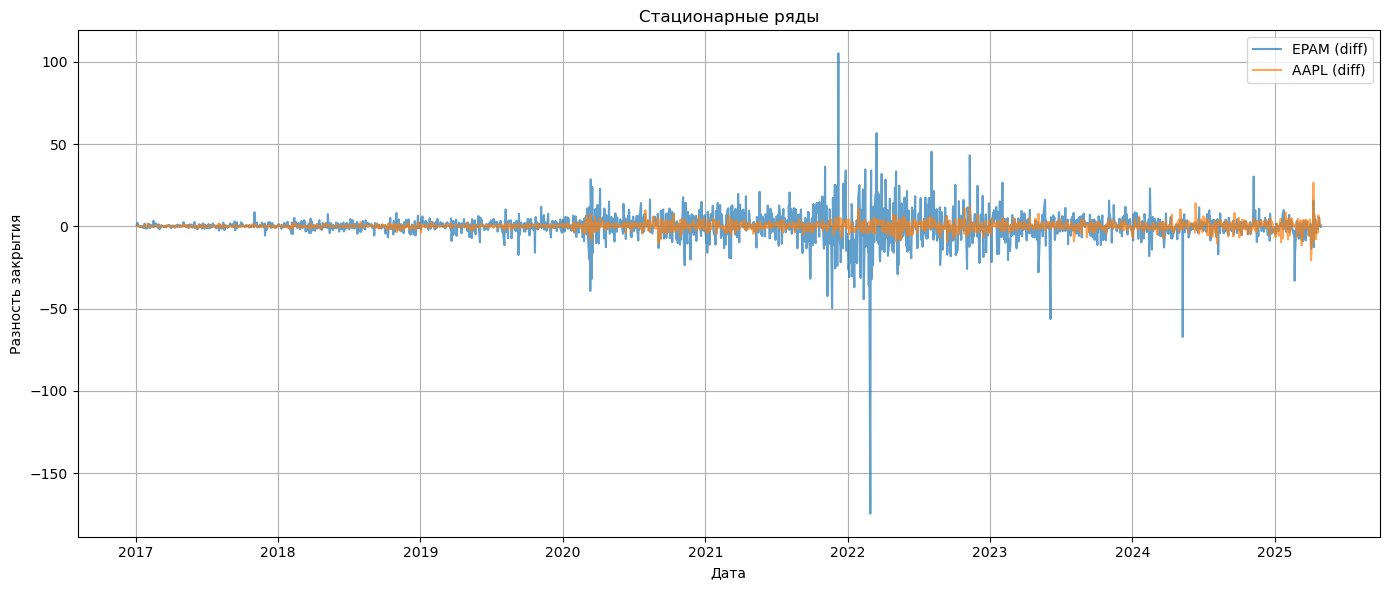

In [21]:
plt.figure(figsize=(14, 6))
plt.plot(df_diff.index, df_diff['EPAM'], label='EPAM (diff)', alpha=0.7)
plt.plot(df_diff.index, df_diff['AAPL'], label='AAPL (diff)', alpha=0.7)
plt.title('Стационарные ряды')
plt.xlabel('Дата')
plt.ylabel('Разность закрытия')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<div style='background-color: lightblue; padding: 10px; border-radius: 10px;'>
    <h4 style='color: darkblue;'> Auto correlations</h4>
</div>

In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

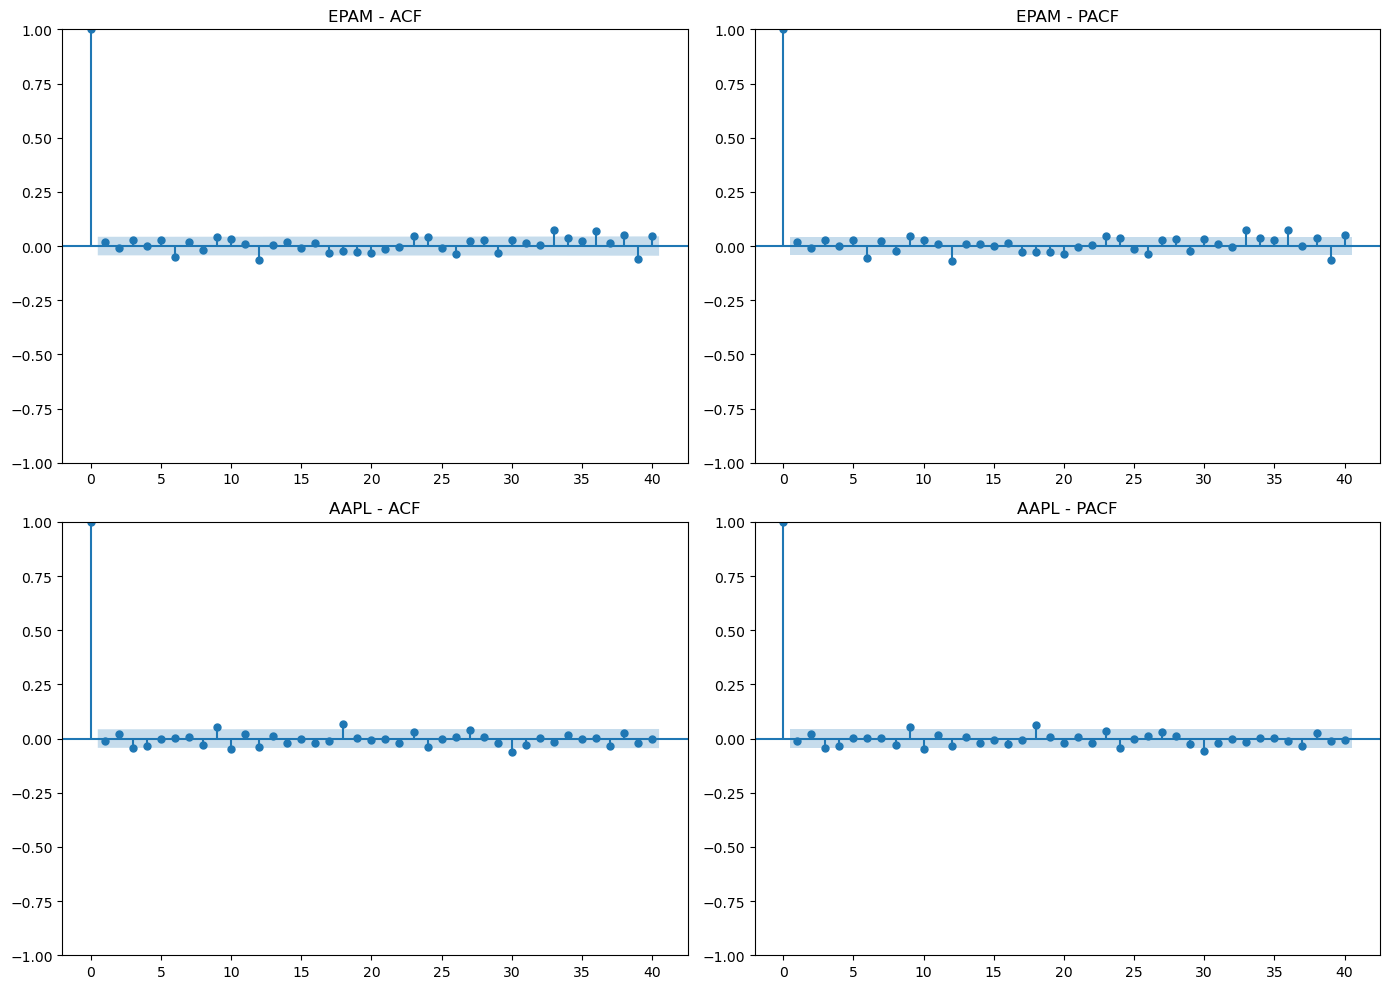

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
# EPAM ACF и PACF
plot_acf(df_diff['EPAM'], ax=axes[0, 0], lags=40, title='EPAM - ACF')
plot_pacf(df_diff['EPAM'], ax=axes[0, 1], lags=40, title='EPAM - PACF', method='ywm')
# AAPL ACF и PACF
plot_acf(df_diff['AAPL'], ax=axes[1, 0], lags=40, title='AAPL - ACF')
plot_pacf(df_diff['AAPL'], ax=axes[1, 1], lags=40, title='AAPL - PACF', method='ywm')
plt.tight_layout()
plt.show()

1. ACF (Autocorrelation Function) - полная автокорреляция. Показывает насколько текущее значение зависит от прошлых значений на разных лагах.
    - EPAM: ACF затухает постепенно, 1 и 2 лаг положительный, 3- отрицательный.
    - AAPL: ACF  обрывается быстро.
3. PACF (Partial Autocorrelation Function — частичная автокорреляция. Показывает связь между текущим значением и лагом, не обращая внимания на промежуточные.
    - EPAM: PACF показывает значимость на 1–2 лагах, затем обрывается.
    - AAPL: PACF обрывается быстро.

<div style='background-color: lightblue; padding: 10px; border-radius: 10px;'>
    <h4 style='color: darkblue;'> Seasonality</h4>
</div>

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [25]:
# Период 252 — примерно количество торговых дней в году
decomposition_epam = seasonal_decompose(df['EPAM'], model='additive', period=252)
decomposition_aapl = seasonal_decompose(df['AAPL'], model='additive', period=252)

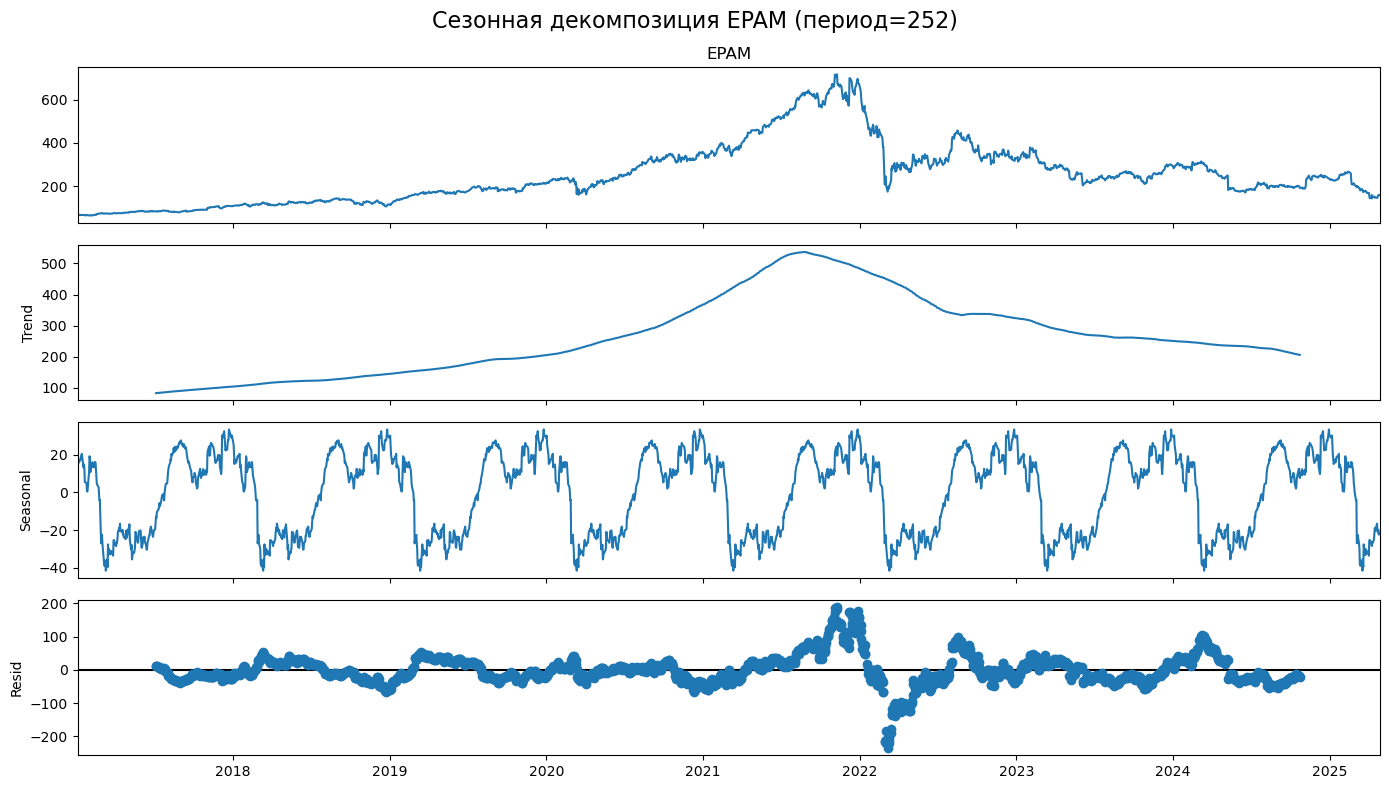

In [26]:
fig_epam = decomposition_epam.plot()
fig_epam.set_size_inches(14, 8)
fig_epam.suptitle('Сезонная декомпозиция EPAM (период=252)', fontsize=16)
plt.tight_layout()
plt.show()

Trend:
 - С 2017 до конца 2021 наблюдается устойчивый рост.
 - После пика в начале 2022 года — тренд сменился на спад, что может быть связано с рыночными/внешними событиями (например, геополитика, санкции и т.д.).

Seasonal:
 - Есть повторяющаяся структура.
 - Сезонность стабильна по амплитуде (80 USD), не растёт и не падает вместе с трендом.

Residual:
 - Остатки довольно волатильны (особенно в 2022 году).
 - Это говорит о том, что в ряду есть внезапные отклонения, не объяснимые ни трендом, ни сезонностью.

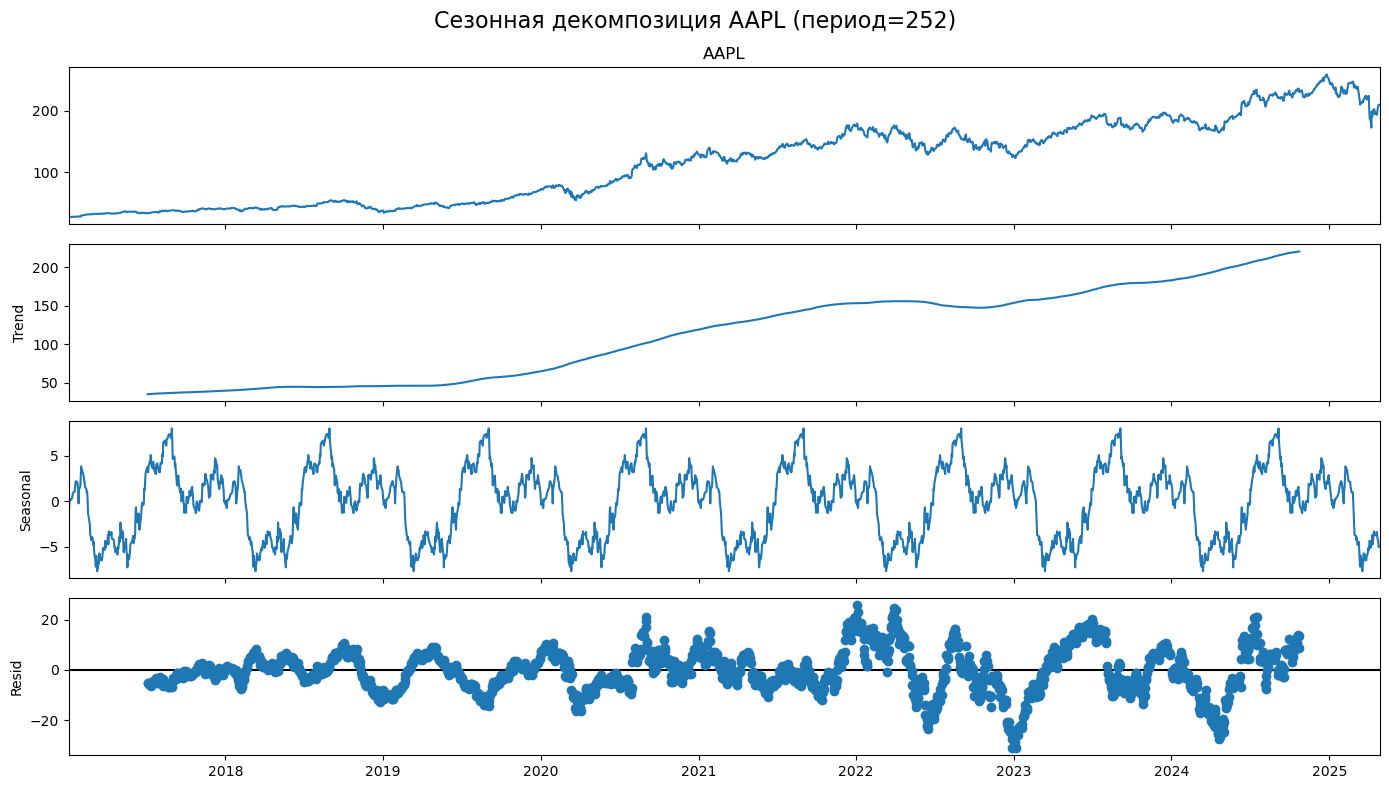

In [27]:
fig_aapl = decomposition_aapl.plot()
fig_aapl.set_size_inches(14, 8)
fig_aapl.suptitle('Сезонная декомпозиция AAPL (период=252)', fontsize=16)
plt.tight_layout()
plt.show()

Trend:
 - Чётко выражен устойчивый рост с 2017 до 2022.
 - С 2022 рост замедляется, но продолжается до 2025.
 - Длинный растущий тренд.

Seasonal:
 - Есть годовая периодичность.
 - Сезонность стабильна по амплитуде (20 USD), не растёт и не падает вместе с трендом.

 Residual (остатки):
 - Распределены умеренно, но видно волатильность — особенно в 2022–2023 годах.
 - Это может отражать рыночные события, новости, отчёты, санкции и пр.

# Task 2:

Выберите <b>1</b> из 2-ух временных рядов <b>из задания 1</b> и сделайте <b>прогноз на ближайший месяц-квартал-полугодие  и год</b>. Модель выбирать исходя из ваших предположений и умозаключений. Необходимо обосновать почему была выбрана та или иная модель и на каких основаниях, в чем она лучше и почему она подходит. Оценить качество прогноза согласно выбранной метрике, проверить качество на отложенной выборке путем применения TimeSeriesSplit. Сформировать отчет с выводами и визуализациями в jupyter notebook’e.

Без отчета с подкрепленными выводами задание считается проваленным (то есть ноутбук с кодом и картинками мне не присылать).

Итоговая оценка за правильно выполненное задание: <b>3 балла.</b>


<div style='background-color: lightblue; padding: 10px; border-radius: 10px;'>
    <h4 style='color: darkblue;'> LinearRegression</h4>
</div>

Для начала выберем линейную регрессию для прогнозирования временного ряда стоимости акциий компании Apple. Она хорошо подходит при наличии тренда, а так же быстро работает, не требует подбора гипер-параметров , что удобно при использовании кросс-валидации. Можно так же использовать как часть ансамбля для определения тренда, а в связке с XGBoost — для корректировки остатков.

In [28]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [29]:
series = df['AAPL']

In [30]:
lags = [1, 2, 3]

In [31]:
features = pd.DataFrame({'y': series})

In [32]:
# Лаги
for lag in lags:
    features[f'lag_{lag}'] = series.shift(lag)

In [33]:
# Удаление строк с NaN после генерации признаков
features = features.dropna()

In [34]:
# Разделение X и y
X = features.drop(columns=['y'])
y = features['y']

In [35]:
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits) 

In [36]:
rmse_scores = []
mae_scores = []
mape_scores = []
r2_scores = []
y_true_all = pd.Series(dtype=float)
y_pred_all = pd.Series(dtype=float)

In [37]:
y_true_all = pd.Series(dtype=float)
y_pred_all = pd.Series(dtype=float)

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Сохраняем предсказания с правильным индексом
    y_pred_all = pd.concat([y_pred_all, pd.Series(y_pred, index=y_test.index)])
    y_true_all = pd.concat([y_true_all, y_test])

    # Метрики (оставим как есть)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    r2 = r2_score(y_test, y_pred)

    rmse_scores.append(rmse)
    mae_scores.append(mae)
    mape_scores.append(mape)
    r2_scores.append(r2)

    print(f"Fold {fold+1}: RMSE={rmse:.2f}, MAE={mae:.2f}, MAPE={mape:.2f}%, R2={r2:.2f}")

Fold 1: RMSE=0.85, MAE=0.61, MAPE=1.32%, R2=0.97
Fold 2: RMSE=2.40, MAE=1.68, MAPE=1.85%, R2=0.99
Fold 3: RMSE=2.68, MAE=2.04, MAPE=1.38%, R2=0.97
Fold 4: RMSE=2.62, MAE=1.96, MAPE=1.24%, R2=0.98
Fold 5: RMSE=3.81, MAE=2.56, MAPE=1.23%, R2=0.98


In [38]:
pd.DataFrame({
    'Fold': [f'Fold {i+1}' for i in range(n_splits)],
    'RMSE': rmse_scores,
    'MAE': mae_scores,
    'MAPE (%)': mape_scores,
    'R2': r2_scores
})

,Fold,RMSE,MAE,MAPE (%),R2
0,Fold 1,0.846164,0.613209,1.323108,0.970441
1,Fold 2,2.397540,1.679938,1.847425,0.990800
2,Fold 3,2.682405,2.035500,1.383960,0.973114
3,Fold 4,2.618808,1.958780,1.242472,0.978944
4,Fold 5,3.814648,2.558853,1.230925,0.976131


 - Все метрики демонстрируют низкие ошибки.
 - Очень высокие значения R² (близкие к 1) на каждом фолде — признак того, что признаки (лаги) хорошо объясняют поведение ряда.
 - MAPE < 2 % говорит о высокой точности относительно текущих цен — особенно важно в задачах трейдинга или управления рисками.

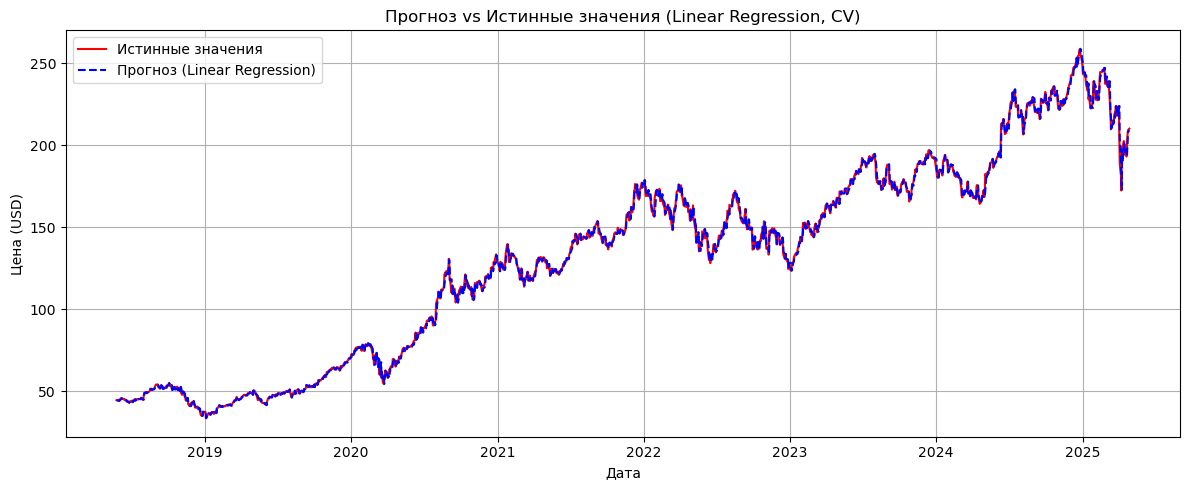

In [39]:
plt.figure(figsize=(12, 5))
plt.plot(y_true_all.index, y_true_all, label='Истинные значения', color='red')
plt.plot(y_pred_all.index, y_pred_all, label='Прогноз (Linear Regression)', linestyle='--', color='blue')
plt.title('Прогноз vs Истинные значения (Linear Regression, CV)')
plt.xlabel('Дата')
plt.ylabel('Цена (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<div style='background-color: lightblue; padding: 10px; border-radius: 10px;'>
    <h4 style='color: darkblue;'> Forecast</h4>
</div>

In [40]:
model_final = LinearRegression()
model_final.fit(X, y)

LinearRegression()

In [41]:
# Обучение модели Linear Regression
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [42]:
# Прогнозы на разные горизонты
forecast_horizon = {
    '1 месяц': 21,
    '1 квартал': 63,
    '0.5 года': 126,
    '1 год': 252
}

In [43]:
# Собираем прогнозы
last_known = features.iloc[-1]
future_forecasts = []

for label, horizon in forecast_horizon.items():
    preds = []
    last_vals = list(last_known[[f'lag_{lag}' for lag in lags]])

    for _ in range(horizon):
        input_vec = np.array([last_vals[-lag] for lag in lags]).reshape(1, -1)
        next_val = model.predict(input_vec)[0]
        preds.append(next_val)
        last_vals.append(next_val)

    forecast_index = pd.date_range(start=series.index[-1], periods=horizon+1, freq='B')[1:]
    future_forecasts.append((label, forecast_index, preds))

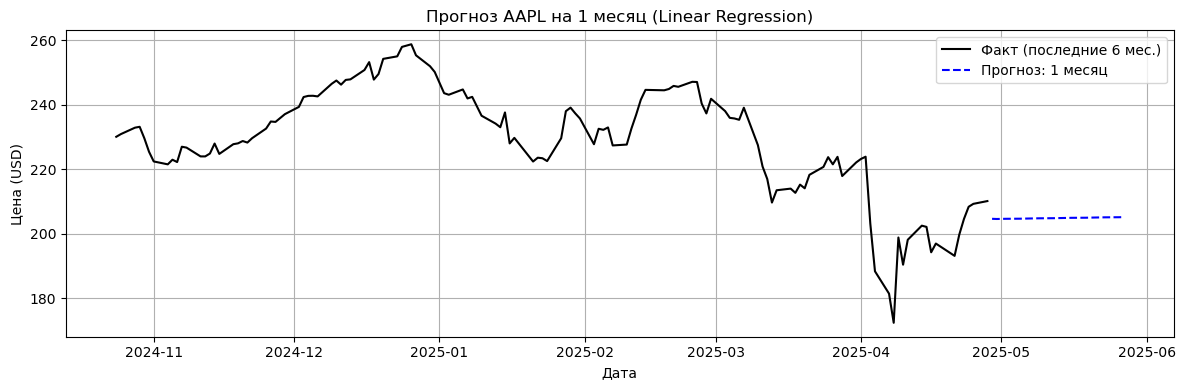

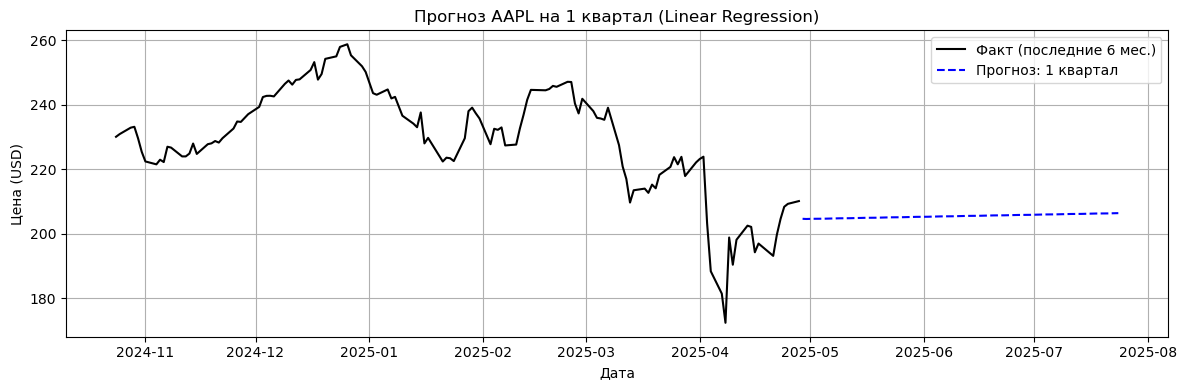

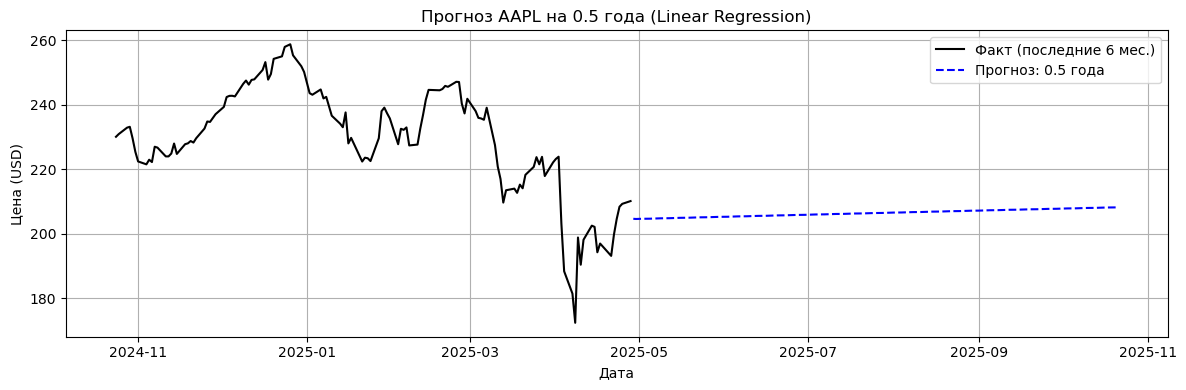

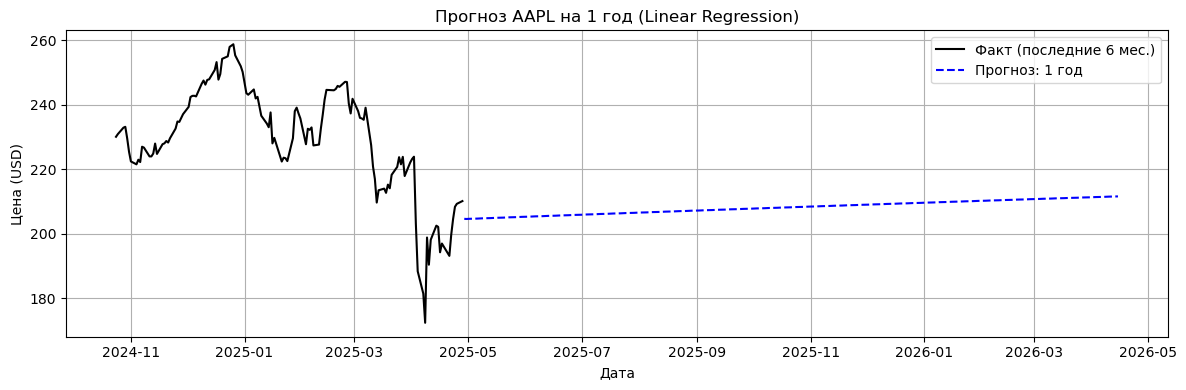

In [44]:
for label, forecast_index, preds in future_forecasts:
    plt.figure(figsize=(12, 4))
    plt.plot(series[-126:], label='Факт (последние 6 мес.)', color='black')
    plt.plot(forecast_index, preds, label=f'Прогноз: {label}', linestyle='--', color='blue')
    plt.title(f'Прогноз AAPL на {label} (Linear Regression)')
    plt.xlabel('Дата')
    plt.ylabel('Цена (USD)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

Во всех горизонтах модель выдает плавный, монотонно растущий прогноз. Линейная регрессия не захватывает сложные паттерны в поведении цены акций. После резкого падения в марте–апреле 2025 модель не прогнозирует сильного восстановления, хотя данные намекают на возможный рост.

<div style='background-color: lightblue; padding: 10px; border-radius: 10px;'>
    <h4 style='color: darkblue;'> Prophet</h4>
</div>

Когда стоит использовать Prophet:
 - Нужен быстрый базовый прогноз, без ручной настройки.
 - Данные содержат сезонные колебания или тренд.

In [45]:
from prophet import Prophet

In [46]:
series = df['AAPL']
# Prophet требует DataFrame с колонками 'ds' и 'y'
df_prophet = pd.DataFrame({'ds': series.index, 'y': series.values})

In [47]:
# TimeSeriesSplit
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

In [48]:
rmse_scores, mae_scores, mape_scores, r2_scores = [], [], [], []
predictions = pd.Series(index=series.index, dtype=float)

In [49]:
for fold, (train_idx, test_idx) in enumerate(tscv.split(df_prophet)):
    train = df_prophet.iloc[train_idx].copy()
    test = df_prophet.iloc[test_idx].copy()

    model = Prophet(daily_seasonality=False, weekly_seasonality=False, 
                    yearly_seasonality=True, seasonality_mode='multiplicative')
    model.fit(train)

    future = test[['ds']]
    forecast = model.predict(future)
    y_true = test['y'].values
    y_pred = forecast['yhat'].values
    predictions.iloc[test_idx] = y_pred

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)

    rmse_scores.append(rmse)
    mae_scores.append(mae)
    mape_scores.append(mape)
    r2_scores.append(r2)

    print(f"Fold {fold+1}: RMSE={rmse:.2f}, MAE={mae:.2f}, MAPE={mape:.2f}%, R2={r2:.2f}")

12:38:11 - cmdstanpy - INFO - Chain [1] start processing
12:38:11 - cmdstanpy - INFO - Chain [1] done processing
12:38:11 - cmdstanpy - INFO - Chain [1] start processing
12:38:11 - cmdstanpy - INFO - Chain [1] done processing
12:38:11 - cmdstanpy - INFO - Chain [1] start processing


Fold 1: RMSE=6.82, MAE=5.69, MAPE=12.91%, R2=-0.92
Fold 2: RMSE=42.90, MAE=36.68, MAPE=36.05%, R2=-1.95


12:38:11 - cmdstanpy - INFO - Chain [1] done processing
12:38:12 - cmdstanpy - INFO - Chain [1] start processing


Fold 3: RMSE=36.12, MAE=29.55, MAPE=20.29%, R2=-3.88


12:38:12 - cmdstanpy - INFO - Chain [1] done processing
12:38:12 - cmdstanpy - INFO - Chain [1] start processing


Fold 4: RMSE=26.89, MAE=21.98, MAPE=14.55%, R2=-1.22


12:38:12 - cmdstanpy - INFO - Chain [1] done processing


Fold 5: RMSE=18.74, MAE=14.97, MAPE=7.14%, R2=0.42


In [50]:
pd.DataFrame({
    'Fold': [f'Fold {i+1}' for i in range(n_splits)],
    'RMSE': rmse_scores,
    'MAE': mae_scores,
    'MAPE (%)': mape_scores,
    'R2': r2_scores
})

,Fold,RMSE,MAE,MAPE (%),R2
0,Fold 1,6.815393,5.692032,12.913682,-0.917647
1,Fold 2,42.902828,36.682782,36.048622,-1.946016
2,Fold 3,36.123145,29.552029,20.293424,-3.875845
3,Fold 4,26.894138,21.982895,14.553931,-1.220677
4,Fold 5,18.736975,14.974400,7.144203,0.424129


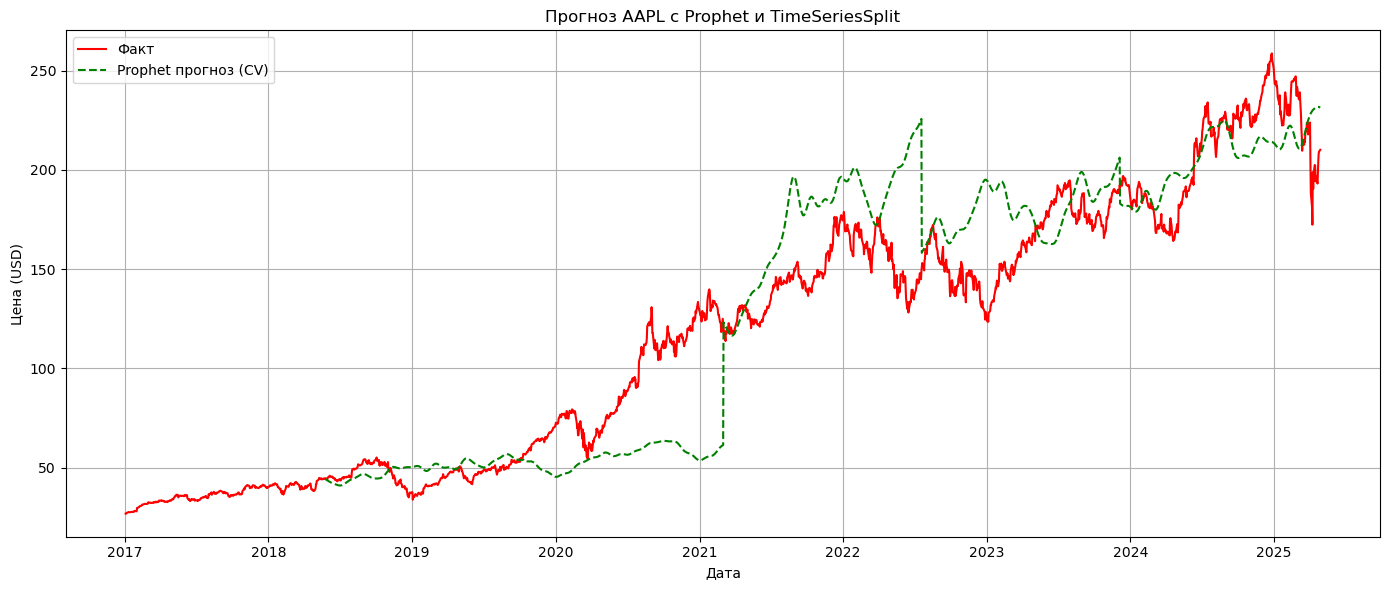

In [51]:
plt.figure(figsize=(14, 6))
plt.plot(series, label='Факт', color='red')
plt.plot(predictions, label='Prophet прогноз (CV)', linestyle='--', color='green')
plt.title('Прогноз AAPL с Prophet и TimeSeriesSplit')
plt.xlabel('Дата')
plt.ylabel('Цена (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<div style='background-color: lightblue; padding: 10px; border-radius: 10px;'>
    <h4 style='color: darkblue;'> Forecast</h4>
</div>

Prophet — это мощный инструмент для прогнозирования будущих значений в данных временных рядов, особенно когда ваши данные имеют повторяющиеся закономерности, такие как ежемесячные или годовые циклы.

In [52]:
# Обучение модели Prophet
model = Prophet(daily_seasonality=False, weekly_seasonality=False, 
                    yearly_seasonality=True, seasonality_mode='multiplicative')
model.fit(df_prophet)

12:38:13 - cmdstanpy - INFO - Chain [1] start processing
12:38:13 - cmdstanpy - INFO - Chain [1] done processing


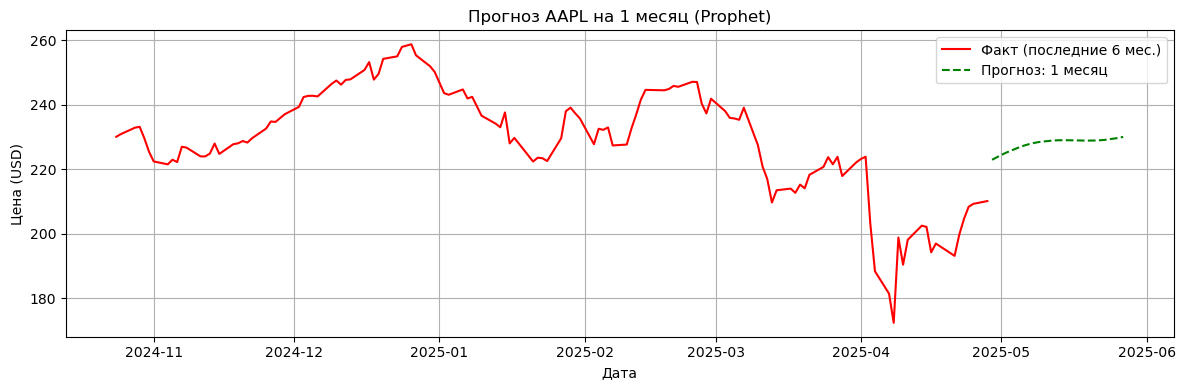

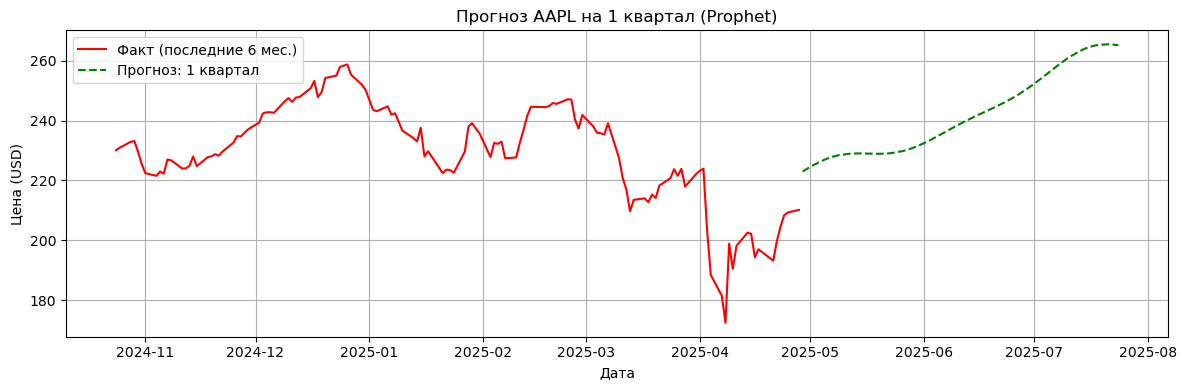

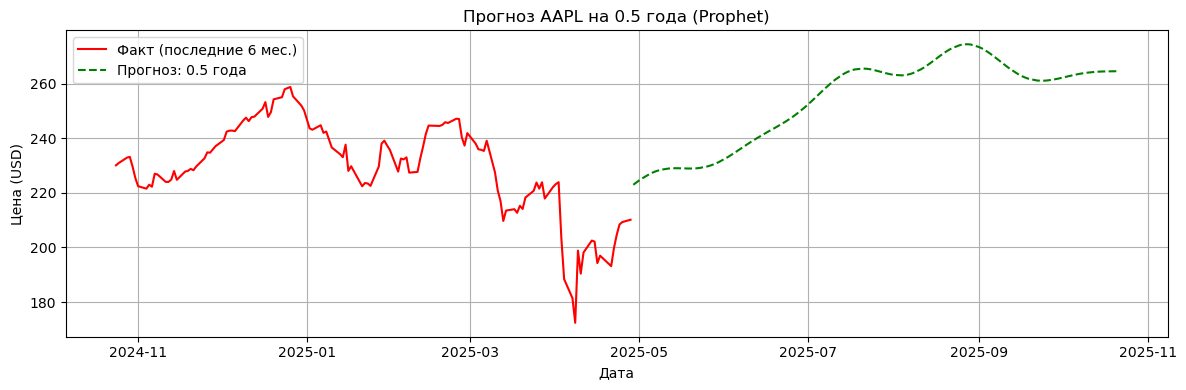

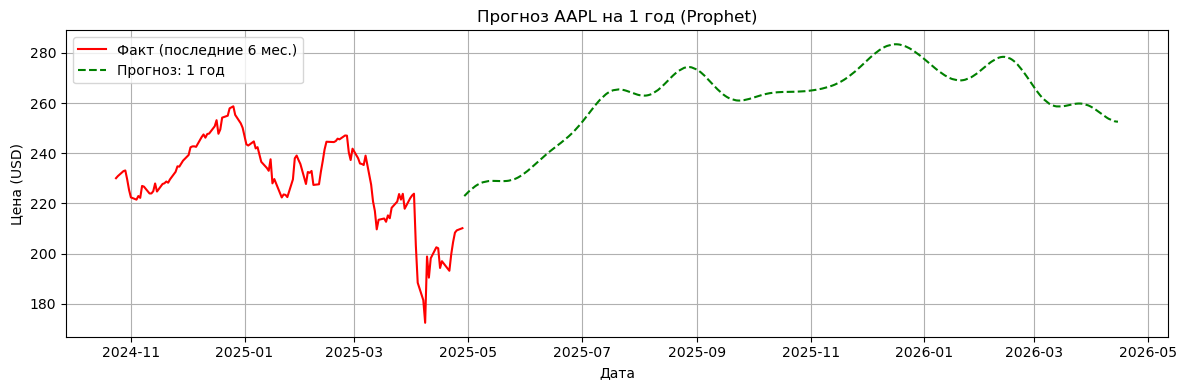

In [53]:
for label, horizon in forecast_horizon.items():
    future = model.make_future_dataframe(periods=horizon, freq='B')
    forecast = model.predict(future)
    
    plt.figure(figsize=(12, 4))
    plt.plot(df_prophet['ds'][-126:], df_prophet['y'][-126:], label='Факт (последние 6 мес.)', color='red')
    plt.plot(forecast['ds'][-horizon:], forecast['yhat'][-horizon:], label=f'Прогноз: {label}', linestyle='--', color='green')
    plt.title(f'Прогноз AAPL на {label} (Prophet)')
    plt.xlabel('Дата')
    plt.ylabel('Цена (USD)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

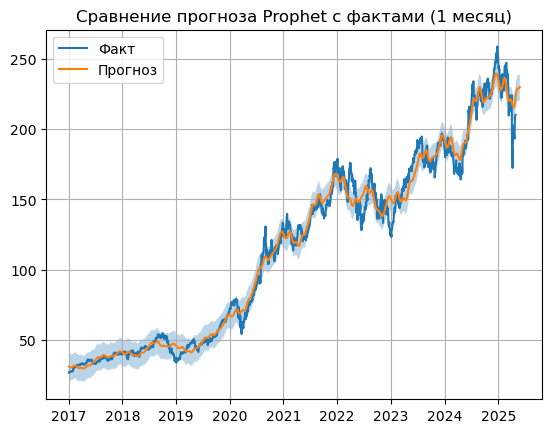

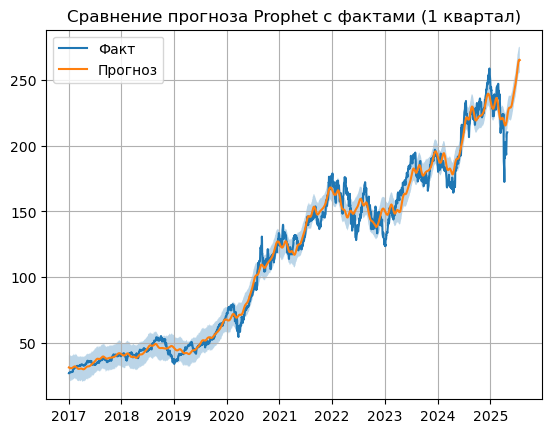

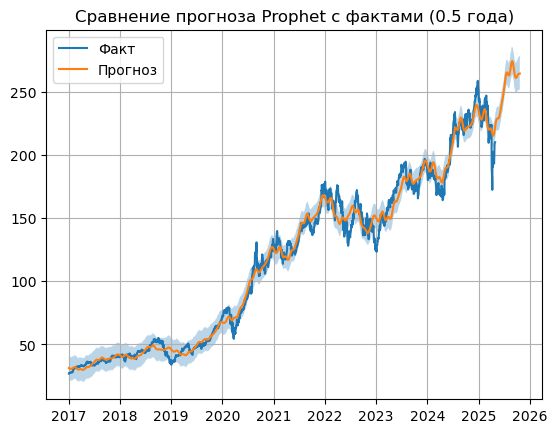

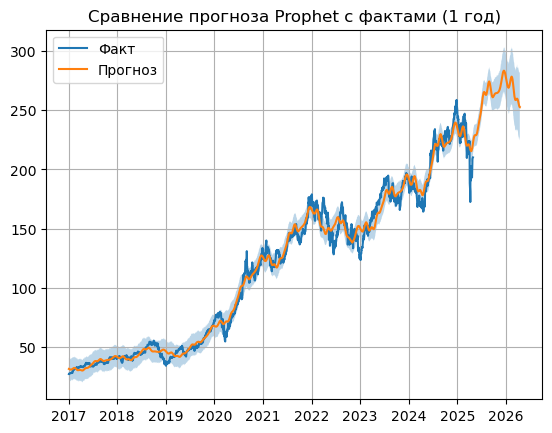

In [54]:
for label, horizon in forecast_horizon.items():
    future = model.make_future_dataframe(periods=horizon, freq='B')
    forecast = model.predict(future)

    plt.plot(df_prophet['ds'], df_prophet['y'], label='Факт')
    plt.plot(forecast['ds'], forecast['yhat'], label='Прогноз')
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], alpha=0.3)
    plt.legend()
    plt.grid(True)
    plt.title(f'Сравнение прогноза Prophet с фактами ({label})')
    plt.show()


Впрогнозе на первый месяц видим умеренный рост, в 1 квартале продолжается восходящий тренд, 6 месяцев - устойчивый рост, 1 год - продолжение тренда.
Несмотря на явное снижение в марте–апреле 2025, Prophet не закладывает его в прогноз, демонстрирует слабую волатильность и периодические колебания. Модель предсказывает устойчивый рост цены AAPL. 

Прогнозная линия (оранжевая) следит за историческим ростом цены AAPL довольно точно. Фактические значения в большинстве случаев укладываются в доверительный интервал, что подтверждает надежность прогноза.

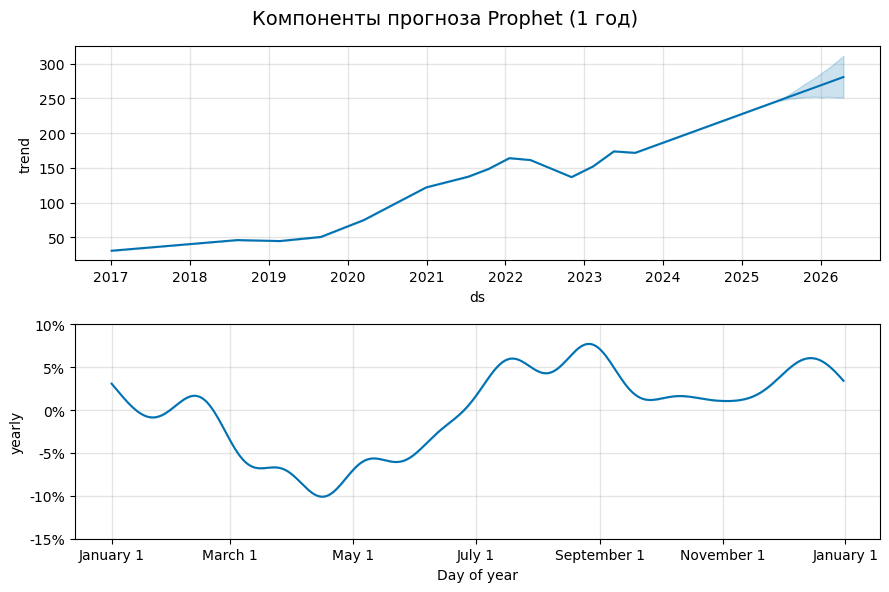

In [55]:
model.plot_components(forecast)
plt.suptitle(f"Компоненты прогноза Prophet ({label})", fontsize=14)
plt.tight_layout()
plt.show()

Тренд (trend component):
 - 	С 2017 по 2025 цена AAPL демонстрирует устойчивый восходящий тренд.
 - 	В 2022–2023 наблюдается временное замедление роста (возможно, связано с внешними событиями).
 - 	В 2025–2026 модель прогнозирует восстановление и дальнейший рост.
 - 	Интервал неопределенности расширяется в будущем, что естественно при долгосрочном прогнозировании.

Годовая сезонность (yearly component):
 - Prophet выявил сезонную структуру доходности в течение года:
 - Апрель–май — исторически слабые месяцы: наблюдается спад.
 - Август–сентябрь — подъём.
 - Декабрь и начало января — снова заметный рост (вероятно, рождественский эффект или период годовой отчетности).

Инвестиционные рекомендации - покупка:
 - модель Prophet прогнозирует устойчивый рост в течение следующего полугодия и года.
 - Подходит для долгосрочных инвесторов, ориентированных на рост стоимости.
 - Продажа в текущей точке могла бы упустить потенциальную прибыль на росте.